# **ML Models comparative analysis on Obesity - CVD risk data**

## 1. Briefing

|            |          |                     |
|------------|----------|---------------------|
| Subject    |          | Machine Learning    |
| Supervisor |          | Prof. Aswin Kannan  |
|            |          |                     |
| Team Name  |          | MT2025724_MT2025732 |
| Member 1   | Name:    | Shreya Gupta              |
|            | Roll No: | MT2025724           |
| Member 2   | Name:    | Anirudh Sharma              |
|            | Roll No: | MT2025732           |
|            |          |                     |

TODO: Add some numericals like the number of models compared, number of data processing techniques applied...

### Keywords

## 2. Summary

* 4–8 bullet points summarizing highest-level conclusions (best model(s), tradeoffs, recommended next steps).
* Short comparative table of winners by criteria (accuracy, latency, model size, fairness, etc.)

## 3. Introduction

* Problem statement and motivation
* Objectives of the comparative study (what questions you will answer)
* Scope (datasets, model families, compute constraints)
* Contributions (what unique analyses you provide — e.g., timing, memory profiling, calibration, fairness tests)


## System Imports

In [151]:
import chime
import random
import time
import json
import functools, itertools
import warnings

import pandas as pd
import numpy as np
import scipy as sp
import sklearn as skl
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pprint import pprint
from tqdm import tqdm

import IPython.display as d

### Notification System Setup

In [152]:
# Set notification sound
chime.theme("material")
chime.info()

### PyPlot Setup

In [153]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
wid_fig = (8, 3)


# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(suptitle: str = None, constrained=False):
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.savefig(f'report/figures/plot_{suptitle}.png', dpi=300)
    compose(plt.suptitle, suptitle, font_suptitle)
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.show()


chime.info()

### Randomizer Setup

In [154]:
default_seed = 1114  # 1114 stands for Minecraftian14, which is me, ofc


def reset_seed(seed=default_seed):
    random.seed(seed)
    np.random.seed(seed)


chime.info()

### Presentor Setup

In [155]:
displayMD = lambda x: display(d.Markdown(x))
kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())
header = lambda n, field: "%s %s" % ("#" * n, field)
quote = lambda field: "\n\n> %s" % field.replace("\n", "\n> ")
list_out = lambda title, list: header(4, "%s\n\n* %s" % (title, "\n* ".join(list)))

# displayMD(header(3, kv("Hmm", "10")))
# displayMD(header(4, kv("Hmm", "10")))
# displayMD(quote(kv("Hmm", "10")))
# displayMD(list_out("Fruits", ["apple", "banana", "orange"]))

### Other Helpers

In [156]:
def flatten(obj):
    if hasattr(obj, '__iter__') and not isinstance(obj, str):
        if hasattr(obj[0], '__iter__') and not isinstance(obj[0], str):
            return list(itertools.chain.from_iterable(obj))
        return obj
    return [obj]

### Transformation Helpers

In [157]:
def pop_drop_column(data, columns=None):
    if isinstance(data, pd.DataFrame): data.drop(columns=columns, inplace=True)
    return columns, None


def pop_log_transform(data, base=np.e):
    return base, np.log(data) / np.log(base)


def pop_root_transform(data, exp=0.5):
    return exp, np.power(data, exp)


def pop_box_cox_transform(data):
    data, lam = sp.stats.boxcox(data)
    return lam, data


def pop_one_hot_encode(data, name=None):
    if isinstance(data, pd.Series) and name is None: name = data.name
    return np.unique(data), pd.get_dummies(data, name)


def pop_soft_ohe(data, split_points):
    produce = []
    produce.append((data < split_points[1]))
    for s, e in zip(split_points[0:-2], split_points[2:]):
        produce.append(data * (data > s) * (data < e))
    produce.append(data * (data > split_points[-2]))
    return split_points, produce


def pop_binarize(data):
    assert len(np.unique_counts(data)) == 2
    pri_val, data = data[0], data == data[0]
    if isinstance(data, pd.Series): data.name = "is_%s_%s" % (data.name, pri_val)
    return pri_val, data


def pop_standardize(data):
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    return (mean, std), (data - mean) / std


def pop_minmax(data):
    min, max = np.min(data, axis=0), np.max(data, axis=0)
    return (min, max), (data - min) / (max - min)


def pop_ordinal_encode(data):
    uniques, encoded = np.unique(data, return_inverse=True)
    if isinstance(data, pd.Series): encoded = pd.Series(encoded, index=data.index, name=data.name)
    return uniques, encoded


def compose_pop(*pop_operations):
    pop_operations = flatten(pop_operations)

    def pop_composed(data):
        arguments = []
        for pop_operation in pop_operations:
            args, data = pop_operation(data)
            if data is None: continue
            arguments.append([pop_operation.__name__, args])
        return arguments, data

    return pop_composed


def pop_round(data, decimals=0):
    return decimals, np.round(data, decimals=decimals)


def pop_derived_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data["BMI"] = data["Weight"] / (data["Height"] ** 2)
    data["Water_Intake_per_Meal"] = data["CH2O"] / (data["NCP"] + 1e-6)
    data["Activity_to_Tech_Ratio"] = data["FAF"] / (data["TUE"] + 0.1)
    data["Healthy_Lifestyle_Score"] = (data["FCVC"] * 0.3 + data["FAF"] * 0.3
                                       + data["CH2O"] * 0.4 - data["FAVC"].map({"yes": 1, "no": 0}))
    data["Has_FamilyRisk_and_FAVC"] = np.where(
        (data["FHWO"] == "yes") & (data["FAVC"] == "yes"), 1, 0)
    data["Calorie_Monitoring_Interaction"] = (data["SCC"].map({"yes": 1, "no": 0})
                                              * data["FAVC"].map({"yes": 1, "no": 0}))
    return None, data


def prepare_pop(pop_operation, *args):
    def pop_prepared(data):
        return pop_operation(data, *args)

    return pop_prepared


def to_ser_op(ds: pd.DataFrame, col, pop_operation, keep_col=False, out_ds=None):
    data = ds[col]
    if not keep_col: ds.drop(columns=flatten(col), inplace=True)
    arg, data = compose_pop(pop_operation)(data)
    if out_ds is not None: ds = out_ds
    if data is None: return arg, ds
    if isinstance(data, list):
        for idx, sample in enumerate(data):
            ds["%s_%d" % (col, idx)] = sample
    elif isinstance(data, pd.DataFrame):
        for column in data.columns:
            ds[column] = data[column]
    else:
        ds[col] = data
    return arg, ds


def select_pipeline_variation(pipeline, index):
    pipeline = pipeline.copy()
    pipeline[1] = [pipeline[1][index]]
    return pipeline


def apply_pipeline(ds: pd.DataFrame, pipeline, to_numpy=True):
    compulsory, permutable = pipeline[0], pipeline[1]
    ds = ds.copy()
    arguments = []
    for pop_operation, columns in compulsory:
        for column in columns:
            if (not isinstance(column, str)) or (column in ds.columns):
                arg, _ = to_ser_op(ds, column, pop_operation, keep_col=False)
                arguments.append(arg)
    if len(permutable) == 0:
        yield arguments, ds.to_numpy() if to_numpy else ds
    for permutation in permutable:
        ds_ans = ds.copy()
        perm_arguments = arguments.copy()
        for pop_operation, columns in permutation:
            for column in columns:
                if (not isinstance(column, str)) or (column in ds_ans.columns):
                    arg, _ = to_ser_op(ds_ans, column, pop_operation, keep_col=False)
                    perm_arguments.append(arg)
        yield perm_arguments, ds_ans.to_numpy() if to_numpy else ds

### Model Helpers

In [158]:
# // TODO Create a model save load function here


def evaluate_model(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    displayMD(header(4, kv('Train Accuracy', model.score(train_x, train_y))))
    displayMD(header(4, kv('Test Accuracy', model.score(test_x, test_y))))
    return model


def save_submission(key, model, data_test_ids, data_test):
    ds_res = pd.DataFrame()
    ds_res['id'] = data_test_ids
    ds_res['WeightCategory'] = model.predict(data_test)
    ds_res.to_csv(f'submission_{key}.csv', index=False)

## Data Loading

In [159]:
# Load data from train and test CSVs - train data is to be used for model training an dtesting, test is to be used for generatign the final predictions
ds_source = pd.read_csv("train.csv")
ds_test = pd.read_csv("test.csv")

ds_source.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)
ds_test.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)

chime.info()

In [160]:
n_samples_all, n_columns = ds_source.shape
n_features_raw = n_columns - 2  # id and targets

target_labels = ds_source['WeightCategory'].unique()
n_targets = len(target_labels)

displayMD(header(4, kv('Number of total samples', n_samples_all)))
displayMD(header(4, kv('Number of total columns', n_columns)))
displayMD('---')
displayMD(header(4, kv('Number of features', n_features_raw)))
displayMD(header(4, kv('Number of classes', n_targets)))

#### **Number of total samples:** `15533`

#### **Number of total columns:** `18`

---

#### **Number of features:** `16`

#### **Number of classes:** `7`

In [161]:
column_full_names = {
    'id': 'Entity Identifier', 'Gender': 'Gender', 'Age': 'Age', 'Height': 'Height', 'Weight': 'Weight',
    'FHWO': 'Family History With Overweight', 'FAVC': 'High Caloric Food Consumption Freq.',
    'FCVC': 'Vegetables Consumption Freq.', 'NCP': 'Main Meals Count', 'CAEC': 'Consumption of Food Between Meals',
    'SMOKE': 'Smoke', 'CH2O': 'Consumption of Water Daily', 'CALC': 'Consumption of alcohol',
    'SCC': 'Calories Consumption Monitoring', 'FAF': 'Physical Activity Freq.', 'TUE': 'Time using Technology Devices',
    'MTRANS': 'Modes of Transportation Used', 'WeightCategory': 'Weight Category', }

In [162]:
info = pd.io.formats.info.DataFrameInfo(
    data=ds_source,
    memory_usage=None,
)
ds_info = pd.DataFrame(zip(info.ids, info.ids.map(column_full_names), info.non_null_counts, info.dtypes),
                       columns=['Column Name', 'Description', 'Non-Null Count', 'Data Type'])

In [163]:
displayMD(header(3, kv('Memory Usage', info.memory_usage_string)))
display(ds_info)

### **Memory Usage:** `2.1+ MB`

,Column Name,Description,Non-Null Count,Data Type
0,id,Entity Identifier,15533,int64
1,Gender,Gender,15533,object
2,Age,Age,15533,float64
3,Height,Height,15533,float64
4,Weight,Weight,15533,float64
5,FHWO,Family History With Overweight,15533,object
6,FAVC,High Caloric Food Consumption Freq.,15533,object
7,FCVC,Vegetables Consumption Freq.,15533,float64
8,NCP,Main Meals Count,15533,float64
9,CAEC,Consumption of Food Between Meals,15533,object


In [164]:
gb_info_by_dtype = ds_info.groupby('Data Type')['Column Name'].apply(list)
display(pd.DataFrame({
    t: items + [''] * (gb_info_by_dtype.map(len).max() - len(items))
    for t, items in gb_info_by_dtype.items()
}))

,int64,float64,object
0,id,Age,Gender
1,,Height,FHWO
2,,Weight,FAVC
3,,FCVC,CAEC
4,,NCP,SMOKE
5,,CH2O,SCC
6,,FAF,CALC
7,,TUE,MTRANS
8,,,WeightCategory


In [165]:
display(ds_source.head(5))

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [166]:
display(ds_source.describe(include='all'))

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
count,15533.000000,15533,15533.000000,15533.000000,15533.000000,15533,15533,15533.000000,15533.000000,15533,15533,15533.000000,15533,15533.000000,15533.000000,15533,15533,15533
unique,NaN,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,5,7
top,NaN,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,NaN,7783,NaN,NaN,NaN,12696,14184,NaN,NaN,13126,15356,NaN,15019,NaN,NaN,11285,12470,2983
mean,7766.000000,NaN,23.816308,1.699918,87.785225,NaN,NaN,2.442917,2.760425,NaN,NaN,2.027626,NaN,0.976968,0.613813,NaN,NaN,NaN
std,4484.135201,NaN,5.663167,0.087670,26.369144,NaN,NaN,0.530895,0.706463,NaN,NaN,0.607733,NaN,0.836841,0.602223,NaN,NaN,NaN
min,0.000000,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,3883.000000,NaN,20.000000,1.630927,66.000000,NaN,NaN,2.000000,3.000000,NaN,NaN,1.796257,NaN,0.007050,0.000000,NaN,NaN,NaN
50%,7766.000000,NaN,22.771612,1.700000,84.000000,NaN,NaN,2.342220,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.566353,NaN,NaN,NaN
75%,11649.000000,NaN,26.000000,1.762921,111.600553,NaN,NaN,3.000000,3.000000,NaN,NaN,2.531456,NaN,1.582675,1.000000,NaN,NaN,NaN


In [167]:
redundant_columns = ['id']
target_columns = ['WeightCategory']

gaussian_features = ['Age', 'Height', 'Weight']
partial_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC']
nary_features = ['CAEC', 'CALC', 'MTRANS']

numerical_features = gaussian_features + partial_features
categorical_features = binary_features + nary_features
all_features = numerical_features + categorical_features

numerical_derived_features = ["BMI", "Water_Intake_per_Meal", "Activity_to_Tech_Ratio", "Healthy_Lifestyle_Score"]
binary_derived_features = ["Has_FamilyRisk_and_FAVC", "Calorie_Monitoring_Interaction"]
derived_features = numerical_derived_features + binary_derived_features

label_encoder = {label: index for index, label in enumerate(target_labels)}
label_decoder = {index: label for index, label in enumerate(target_labels)}

## Data Presentation

#### Missing Value Detection

In [168]:
display(ds_source.isnull().sum().to_frame(name='Missing_Count'))

,Missing_Count
id,0
Gender,0
Age,0
Height,0
Weight,0
FHWO,0
FAVC,0
FCVC,0
NCP,0
CAEC,0


**Observation**: There is not a single missing value in any of the columns

**Inference**: The dataset is pretty good in this department! We do not have to perform any sorts of missing value handling procedures like removal, imputation or flagging.

#### Outlier Detection

In [169]:
def count_outliers(ds: pd.DataFrame, column: str):
    quan25 = ds[column].quantile(0.25)
    quan75 = ds[column].quantile(0.75)
    iqr = quan75 - quan25
    lower_limit = quan25 - 1.5 * iqr
    upper_limit = quan75 + 1.5 * iqr
    return len(ds[(ds[column] > upper_limit) | (ds[column] < lower_limit)])


_ds_num = ds_source[numerical_features]
display(pd.DataFrame(zip(_ds_num.columns, [count_outliers(_ds_num, col) for col in _ds_num.columns]),
                     columns=['', 'Outliers_Count']))

,,Outliers_Count
0,Age,792
1,Height,4
2,Weight,0
3,FCVC,0
4,NCP,4548
5,CH2O,0
6,FAF,0
7,TUE,0


**Observation**: TODO

**Inference**: TODO

#### Feature Distribution

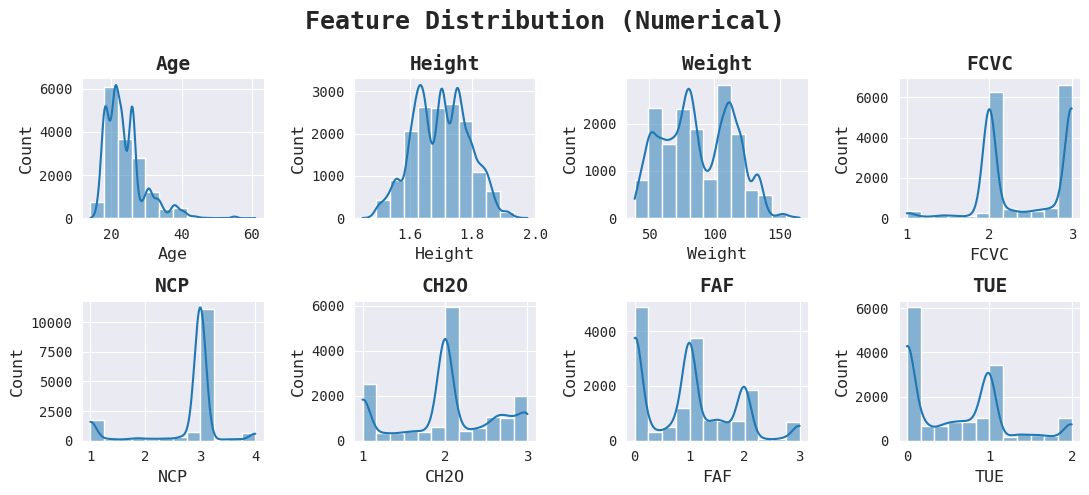

In [170]:
fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), numerical_features):
    sns.histplot(ds_source[col], kde=True, bins=12, ax=ax)
    annotate_plot(ax, col)
conclude_plot("Feature Distribution (Numerical)")

**Observation**:
* Age dataset is clearly far too skewed towards the left
* All features other than Age, Height and Weight do not follow a conventional distribution. <br/> Rather, they have a characteristic misture of discrete sampling and a gaussian likeness.
* TODO

**Inference**: TODO

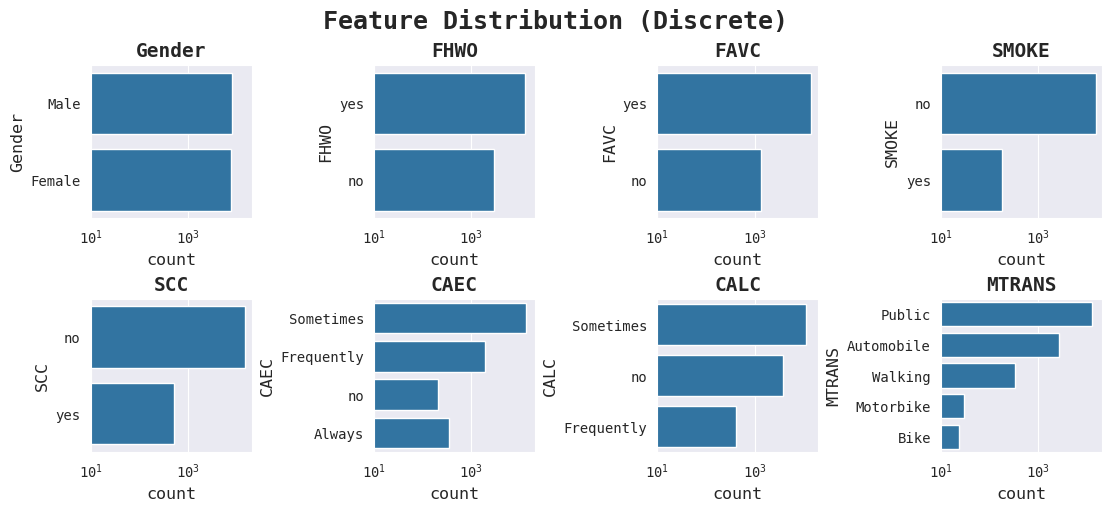

In [171]:
fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), categorical_features):
    sns.countplot(ds_source[col], ax=ax)
    annotate_plot(ax, col), ax.set_xscale('log'), ax.set_xlim(10, 20000)
    if col == 'MTRANS': ax.set_yticks(range(5), ['Public', 'Automobile', 'Walking', 'Motorbike', 'Bike'], **font_ticks)
conclude_plot("Feature Distribution (Discrete)", constrained=True)

**Observation**:
* Gender is very well distributed
* Family History With Overweight and High Caloric Food Consumption Freq has small skewedness
* Smoke and Calories Consumption Monitoring has moderate skewedness
* Consumption of Food Between Meals, Consumption of alcohol, and Means of Transportation Used are extremely skewedness

**Inference**:
* TODO

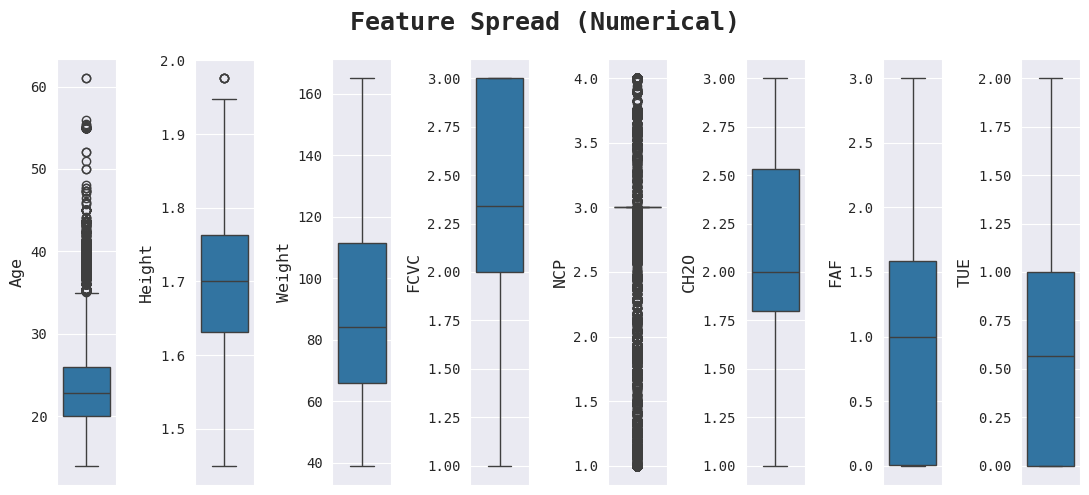

In [172]:
fig, axs = plt.subplots(1, 8, figsize=(max_fig_width, 5))
for ax, column in zip(flatten(axs), numerical_features):
    sns.boxplot(y=column, data=ds_source, ax=ax)
conclude_plot("Feature Spread (Numerical)")

**Observation**:
* TODO

**Inference**:
* TODO

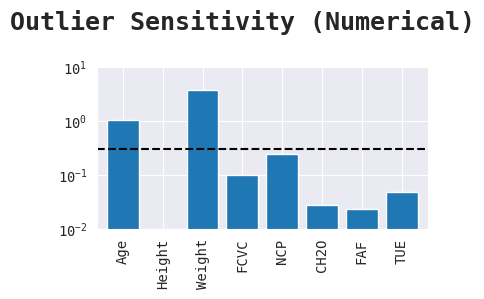

In [173]:
plt.figure(figsize=sml_fig)
_ds_num = ds_source[numerical_features]
(_ds_num.mean() - _ds_num.median()).abs().plot(kind='bar', width=0.8)
plt.yscale('log'), plt.ylim(0.01, 10)
plt.axhline(0.3, color='black', linestyle='--')
conclude_plot("Outlier Sensitivity (Numerical)")

**Observation**:
* TODO

**Inference**:
* TODO

## Data Pre-Processing

### Experimenting on AGE Feature

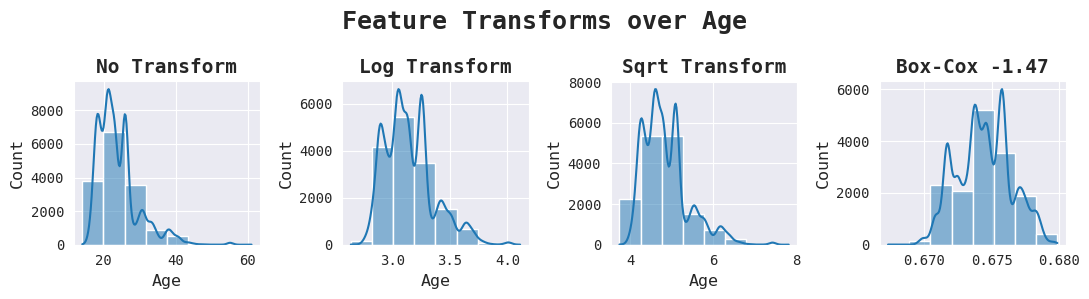

In [174]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_bclam, _bcage = pop_box_cox_transform(ds_source['Age'])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['Age']],
        ['Log Transform', pop_log_transform(ds_source['Age'])[1]],
        ['Sqrt Transform', pop_root_transform(ds_source['Age'])[1]],
        ['Box-Cox %.2f' % _bclam, _bcage],
)):
    sns.histplot(data, kde=True, bins=8, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Feature Transforms over Age")

### Experimenting on NCP Feature

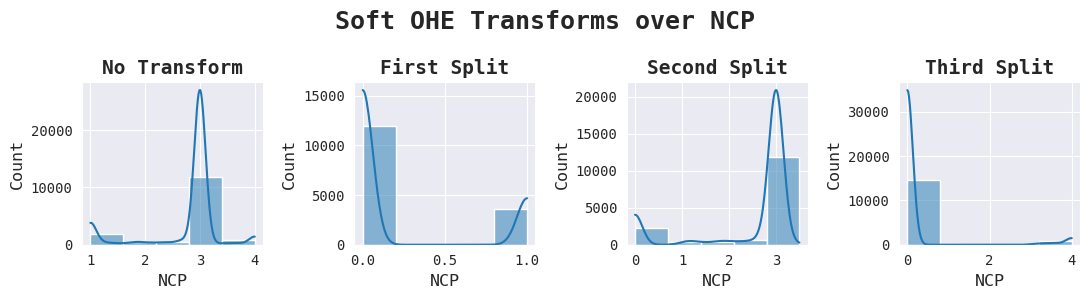

In [175]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_, _scd_ncp = pop_soft_ohe(ds_source['NCP'], [1, 3, 3.5])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['NCP']],
        ['First Split', _scd_ncp[0]],
        ['Second Split', _scd_ncp[1]],
        ['Third Split', _scd_ncp[2]],
)):
    sns.histplot(data, kde=True, bins=5, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Soft OHE Transforms over NCP")

### Outlier Handling

In [176]:
# TODO

## Data Pipelining

#### For Regression Based Models

In [177]:
regression_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory']),
        (pop_binarize, binary_features),
        (pop_one_hot_encode, nary_features),
    ],
    [  # Permutable ones
        [  # No Chill
        ],
        [  # Simple Life
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, numerical_features),
        ],
        [  # Encoded Q-Conts
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, gaussian_features),
            (pop_round, partial_features),
            (pop_one_hot_encode, partial_features),
        ],
        [  # Soft Hot Encode
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, gaussian_features),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), ['FCVC']),
            (prepare_pop(pop_soft_ohe, [1, 3, 4]), ['NCP']),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), ['CH2O']),
            (prepare_pop(pop_soft_ohe, [0, 1, 2, 3]), ['FAF']),
            (prepare_pop(pop_soft_ohe, [0, 1, 2]), ['TUE']),
        ],
    ],
]
regression_pipeline_derived = regression_pipeline.copy()
regression_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory']),
    (pop_derived_features, [all_features]),
    (pop_binarize, binary_features),
    (pop_one_hot_encode, nary_features),
    (pop_standardize, numerical_derived_features),
    (pop_binarize, binary_derived_features),
]
# next(apply_pipeline(ds_source.head(10), regression_pipeline_derived, False))[1]

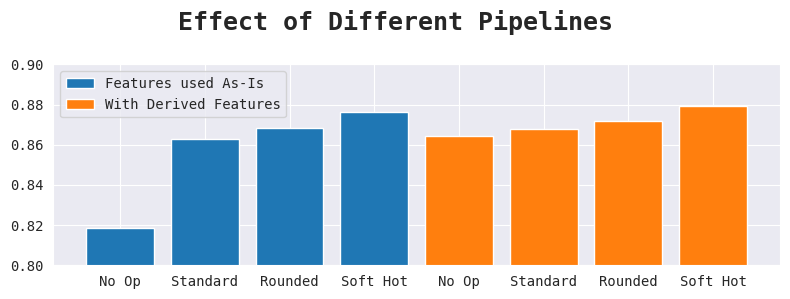

In [178]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'])[1].to_numpy()
_scores = []

for pipeline in [regression_pipeline, regression_pipeline_derived]:
    for args, ds_sample in apply_pipeline(ds_source, pipeline):
        model = skl.linear_model.LogisticRegression(max_iter=1000)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)
            model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plt.figure(figsize=wid_fig)
plt.bar(range(4), _scores[:4], label='Features used As-Is')
plt.bar(range(4, 8), _scores[4:], label='With Derived Features')
plt.xticks(range(len(_scores)), ['No Op', 'Standard', 'Rounded', 'Soft Hot'] * 2)
plt.ylim(min(0.8, np.min(_scores)), max(0.9, np.max(_scores)))
plt.legend()
conclude_plot("Effect of Different Pipelines")

#### For Tree Based Models

In [179]:
tree_pipeline = [
    [  # Compulsory ones
        (pop_binarize, binary_features),
        (pop_drop_column, ['id', 'WeightCategory']),
    ],
    [  # Permutable ones
        [  # Ordinal Encoded
            (pop_ordinal_encode, nary_features),
        ],
        [  # One Hot Encoded
            (pop_one_hot_encode, nary_features),
        ],
    ],
]
tree_pipeline_derived = tree_pipeline.copy()
tree_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory']),
    (pop_derived_features, [all_features]),
    (pop_binarize, binary_features),
    (pop_standardize, numerical_derived_features),
    (pop_binarize, binary_derived_features),
]

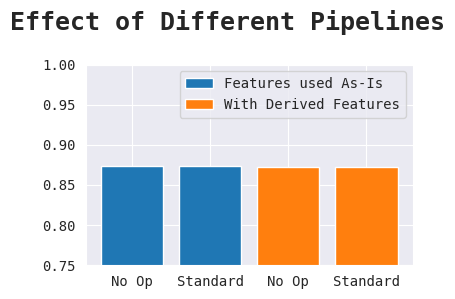

In [180]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'])[1].to_numpy()
_scores = []

for pipeline in [tree_pipeline, tree_pipeline_derived]:
    for args, ds_sample in apply_pipeline(ds_source, pipeline):
        model = skl.tree.DecisionTreeClassifier(max_depth=7)
        model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plt.figure(figsize=sml_fig)
plt.bar(range(2), _scores[:2], label='Features used As-Is')
plt.bar(range(2, 4), _scores[2:], label='With Derived Features')
plt.xticks(range(len(_scores)), ['No Op', 'Standard'] * 2)
plt.ylim(min(0.75, np.min(_scores)), max(1.0, np.max(_scores)))
plt.legend()
conclude_plot("Effect of Different Pipelines")

## Modelling

### Experiment Setup

### Logistic Regression

In [56]:
pipeline = select_pipeline_variation(regression_pipeline_derived, 3)
arguments, ds_source_regression = next(apply_pipeline(ds_source, pipeline))

data_x, data_y = ds_source_regression, ds_source['WeightCategory'].to_numpy()
train_x, test_x, train_y, test_y = skl.model_selection.train_test_split(
    data_x, data_y, test_size=0.33, random_state=default_seed)

_, data_test = next(apply_pipeline(ds_test, pipeline))
data_test_ids = ds_test['id'].to_numpy()

#### Simple LR Example

In [57]:
model = skl.linear_model.LogisticRegression(max_iter=1000)
evaluate_model(model, train_x, train_y, test_x, test_y)
save_submission("SimpleLRModel", model, data_test_ids, data_test)
chime.info()

#### **Train Accuracy:** `0.8802728932449313`

#### **Test Accuracy:** `0.8718298868513461`

#### Grid Searched Logistic Regression

In [111]:
start_time = time.perf_counter()

history = []
for penalty, c, solver in itertools.product(
        [None, 'l1', 'l2', 'elasticnet'],
        [1.0, 0.1],
        ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
):
    if penalty is None and c != 1.0: continue
    l1_ratio = 0.5 if penalty == 'elasticnet' else None
    key = f'penalty={penalty},c={c},solver={solver}'
    print("Training", key)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = skl.linear_model.LogisticRegression(
                penalty=penalty, C=c, solver=solver, l1_ratio=l1_ratio,
                max_iter=1000, n_jobs=15)
            model.fit(train_x, train_y)
            history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                                  'val score': model.score(test_x, test_y)}])
    except Exception as e:
        print("Not possible", e)

best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])
save_submission('GSLR_' + best_config, best_model, data_test_ids, data_test)
displayMD(header(4, kv('Best Val Accuracy', best_score)))
displayMD(header(4, kv('Time Elapsed', "{time.perf_counter() - start_time:.4f} seconds")))
chime.success()

Training penalty=None,c=1.0,solver=lbfgs
Training penalty=None,c=1.0,solver=liblinear
Not possible penalty=None is not supported for the liblinear solver
Training penalty=None,c=1.0,solver=newton-cg
Training penalty=None,c=1.0,solver=newton-cholesky
Training penalty=None,c=1.0,solver=sag
Training penalty=None,c=1.0,solver=saga
Training penalty=l1,c=1.0,solver=lbfgs
Not possible Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Training penalty=l1,c=1.0,solver=liblinear
Training penalty=l1,c=1.0,solver=newton-cg
Not possible Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Training penalty=l1,c=1.0,solver=newton-cholesky
Not possible Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Training penalty=l1,c=1.0,solver=sag
Not possible Solver sag supports only 'l2' or None penalties, got l1 penalty.
Training penalty=l1,c=1.0,solver=saga
Training penalty=l1,c=0.1,solver=lbfgs
Not possible Solver lbfgs supports only 'l2' or Non

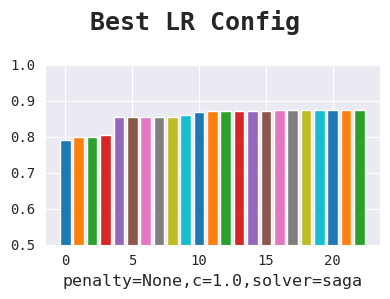

In [112]:
plt.figure(figsize=sml_fig)
_hist = sorted([[x[1]['val score'], x] for x in history])
for idx, (score, _) in enumerate(_hist):
    plt.bar(idx, score)
plt.xlabel(_hist[-1][1][0])
plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
conclude_plot("Best LR Config")

### Decision Tree

In [128]:
pipeline = select_pipeline_variation(tree_pipeline, 0)
arguments, ds_source_regression = next(apply_pipeline(ds_source, pipeline))

data_x, data_y = ds_source_regression, ds_source['WeightCategory'].to_numpy()
train_x, test_x, train_y, test_y = skl.model_selection.train_test_split(
    data_x, data_y, test_size=0.33, random_state=default_seed)

_, data_test = next(apply_pipeline(ds_test, pipeline))
data_test_ids = ds_test['id'].to_numpy()

#### Simple DT Example

In [129]:
model = skl.tree.DecisionTreeClassifier(max_depth=9)
evaluate_model(model, train_x, train_y, test_x, test_y)
save_submission("SimpleDTModel", model, data_test_ids, data_test)
chime.info()

#### **Train Accuracy:** `0.9062169693475546`

#### **Test Accuracy:** `0.8655872024970738`

#### Grid Searched Decision Tree

In [130]:
start_time = time.perf_counter()

history = []
for criterion, max_depth in itertools.product(
        ['gini', 'entropy'],
        range(5, 21),
):
    key = f'criterion={criterion},max_depth={max_depth}'
    print("Training", key)
    model = skl.tree.DecisionTreeClassifier(max_depth=max_depth)
    model.fit(train_x, train_y)
    history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                          'val score': model.score(test_x, test_y)}])

best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])
save_submission('GSDT_' + best_config, best_model, data_test_ids, data_test)
displayMD(header(4, kv('Best Val Accuracy', best_score)))
displayMD(header(4, kv('Time Elapsed', f"{time.perf_counter() - start_time:.4f} seconds")))
chime.success()

Training criterion=gini,max_depth=5
Training criterion=gini,max_depth=6
Training criterion=gini,max_depth=7
Training criterion=gini,max_depth=8
Training criterion=gini,max_depth=9
Training criterion=gini,max_depth=10
Training criterion=gini,max_depth=11
Training criterion=gini,max_depth=12
Training criterion=gini,max_depth=13
Training criterion=gini,max_depth=14
Training criterion=gini,max_depth=15
Training criterion=gini,max_depth=16
Training criterion=gini,max_depth=17
Training criterion=gini,max_depth=18
Training criterion=gini,max_depth=19
Training criterion=gini,max_depth=20
Training criterion=entropy,max_depth=5
Training criterion=entropy,max_depth=6
Training criterion=entropy,max_depth=7
Training criterion=entropy,max_depth=8
Training criterion=entropy,max_depth=9
Training criterion=entropy,max_depth=10
Training criterion=entropy,max_depth=11
Training criterion=entropy,max_depth=12
Training criterion=entropy,max_depth=13
Training criterion=entropy,max_depth=14
Training criterion

#### **Best Val Accuracy:** `0.87065938353492`

#### **Time Elapsed:** `2.2215 seconds`

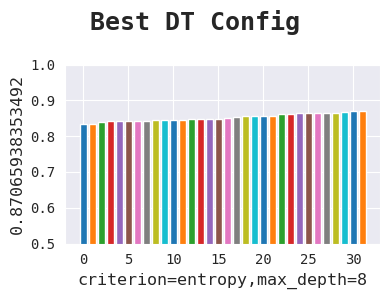

In [131]:
plt.figure(figsize=sml_fig)
_hist = sorted([[x[1]['val score'], x] for x in history])
for idx, (score, _) in enumerate(_hist):
    plt.bar(idx, score)
plt.ylabel(_hist[-1][0])
plt.xlabel(_hist[-1][1][0])
plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
conclude_plot("Best DT Config")

### AdaBoost

#### Simple AB Example

In [132]:
model = skl.ensemble.AdaBoostClassifier()
evaluate_model(model, train_x, train_y, test_x, test_y)
save_submission("SimpleABModel", model, data_test_ids, data_test)
chime.info()

#### **Train Accuracy:** `0.6522532910540982`

#### **Test Accuracy:** `0.6626999609832228`

#### Grid Searched AdaBoost

In [133]:
start_time = time.perf_counter()

history = []
for n_estimators, learning_rate in itertools.product(
        range(10, 101, 10),
        [1.0, 0.1],
):
    key = f'n_estimators={n_estimators},learning_rate={learning_rate}'
    print("Training", key)
    model = skl.ensemble.AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    model.fit(train_x, train_y)
    history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                          'val score': model.score(test_x, test_y)}])

best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])
save_submission('GSAB_' + best_config, best_model, data_test_ids, data_test)
displayMD(header(4, kv('Best Val Accuracy', best_score)))
displayMD(header(4, kv('Time Elapsed', f"{time.perf_counter() - start_time:.4f} seconds")))
chime.success()

Training n_estimators=10,learning_rate=1.0
Training n_estimators=10,learning_rate=0.1
Training n_estimators=20,learning_rate=1.0
Training n_estimators=20,learning_rate=0.1
Training n_estimators=30,learning_rate=1.0
Training n_estimators=30,learning_rate=0.1
Training n_estimators=40,learning_rate=1.0
Training n_estimators=40,learning_rate=0.1
Training n_estimators=50,learning_rate=1.0
Training n_estimators=50,learning_rate=0.1
Training n_estimators=60,learning_rate=1.0
Training n_estimators=60,learning_rate=0.1
Training n_estimators=70,learning_rate=1.0
Training n_estimators=70,learning_rate=0.1
Training n_estimators=80,learning_rate=1.0
Training n_estimators=80,learning_rate=0.1
Training n_estimators=90,learning_rate=1.0
Training n_estimators=90,learning_rate=0.1
Training n_estimators=100,learning_rate=1.0
Training n_estimators=100,learning_rate=0.1


#### **Best Val Accuracy:** `0.7247366367538042`

#### **Time Elapsed:** `29.1939 seconds`

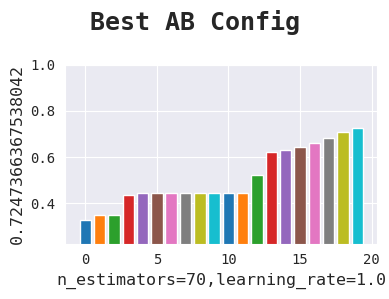

In [136]:
plt.figure(figsize=sml_fig)
_hist = sorted([[x[1]['val score'], x] for x in history])
for idx, (score, _) in enumerate(_hist):
    plt.bar(idx, score)
plt.ylabel(_hist[-1][0])
plt.xlabel(_hist[-1][1][0])
plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
conclude_plot("Best AB Config")

### Random Forest

#### Simple RF Example

In [137]:
model = skl.ensemble.RandomForestClassifier()
evaluate_model(model, train_x, train_y, test_x, test_y)
save_submission("SimpleRFModel", model, data_test_ids, data_test)
chime.info()

#### **Train Accuracy:** `1.0`

#### **Test Accuracy:** `0.889387436597737`

#### Grid Searched Random Forest

In [138]:
start_time = time.perf_counter()

history = []
for n_estimators, max_depth in itertools.product(
        range(50, 201, 10),
        range(15, 21),
):
    key = f'n_estimators={n_estimators},max_depth={max_depth}'
    print("Training", key)
    model = skl.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                                random_state=default_seed, n_jobs=-1)
    model.fit(train_x, train_y)
    history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                          'val score': model.score(test_x, test_y)}])

best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])
save_submission('GSRF_' + best_config, best_model, data_test_ids, data_test)
displayMD(header(4, kv('Best Val Accuracy', best_score)))
displayMD(header(4, kv('Time Elapsed', f"{time.perf_counter() - start_time:.4f} seconds")))
chime.success()

Training n_estimators=50,max_depth=15
Training n_estimators=50,max_depth=16
Training n_estimators=50,max_depth=17
Training n_estimators=50,max_depth=18
Training n_estimators=50,max_depth=19
Training n_estimators=50,max_depth=20
Training n_estimators=60,max_depth=15
Training n_estimators=60,max_depth=16
Training n_estimators=60,max_depth=17
Training n_estimators=60,max_depth=18
Training n_estimators=60,max_depth=19
Training n_estimators=60,max_depth=20
Training n_estimators=70,max_depth=15
Training n_estimators=70,max_depth=16
Training n_estimators=70,max_depth=17
Training n_estimators=70,max_depth=18
Training n_estimators=70,max_depth=19
Training n_estimators=70,max_depth=20
Training n_estimators=80,max_depth=15
Training n_estimators=80,max_depth=16
Training n_estimators=80,max_depth=17
Training n_estimators=80,max_depth=18
Training n_estimators=80,max_depth=19
Training n_estimators=80,max_depth=20
Training n_estimators=90,max_depth=15
Training n_estimators=90,max_depth=16
Training n_e

#### **Best Val Accuracy:** `0.8969957081545065`

#### **Time Elapsed:** `136.2627 seconds`

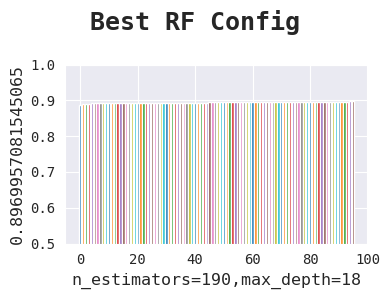

In [139]:
plt.figure(figsize=sml_fig)
_hist = sorted([[x[1]['val score'], x] for x in history])
for idx, (score, _) in enumerate(_hist):
    plt.bar(idx, score)
plt.ylabel(_hist[-1][0])
plt.xlabel(_hist[-1][1][0])
plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
conclude_plot("Best RF Config")

In [ ]:
# TODO: Implement this pop
ds_source['MTRANS'] = ds_source['MTRANS'].map(lambda x: x if x in ('Public_Transportation', 'Automobile') else 'Others')
ds_test['MTRANS'] = ds_test['MTRANS'].map(lambda x: x if x in ('Public_Transportation', 'Automobile') else 'Others')

In [ ]:
# TODO: Correlation Matrix

TVT S

Mdel

In [ ]:
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [ ]:
ds_source.shape

In [36]:
data_x.shape

(15533, 24)

In [37]:
data_test.shape

(5225, 24)

In [38]:
ds_test.shape

(5225, 16)

In [43]:
def save_submission(key, model):
    ds_res = pd.DataFrame()
    ds_res['id'] = ds_test_ids
    ds_res['WeightCategory'] = model.predict(data_test)
    ds_res['WeightCategory'] = ds_res['WeightCategory'].map(labels_decoder)
    ds_res.to_csv(f'submission_{key}.csv', index=False)

In [40]:
data_test.shape

(5225, 24)

In [41]:
model = skl.linear_model.LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)
print('Train', model.score(x_train, y_train))
print('Test ', model.score(x_test, y_test))
chime.info()

Train 0.8641558023499115
Test  0.8619246861924686


In [44]:
save_submission('lr', model)

In [33]:
# history = {}
# for penalty, c, solver in itertools.product(
#         [None, 'l1', 'l2', 'elasticnet'],
#         [1.0],
#         ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# ):
#     key = f'penalty={penalty},c={c},solver={solver}'
#     print("Training", key)
#     try:
#         model = skl.linear_model.LogisticRegression(
#             penalty=penalty, C=c, solver=solver,
#             max_iter=1000, n_jobs=-1)
#         model.fit(data_x, data_y)
#         history[key] = {'model': model, 'score': model.score(data_x, data_y)}
#     except Exception as e:
#         print("Not possible", e)

In [34]:
# history = {}
# for penalty, c, solver in itertools.product(
#         [None, 'l1', 'l2', 'elasticnet'],
#         [1.0],
#         ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# ):
#     key = f'penalty={penalty},c={c},solver={solver}'
#     print("Training", key)
#     try:
#         model = skl.linear_model.LogisticRegression(
#             penalty=penalty, C=c, solver=solver,
#             max_iter=1000, n_jobs=-1)
#         model.fit(data_x, data_y)
#         history[key] = {'model': model, 'score': model.score(data_x, data_y)}
#     except Exception as e:
#         print("Not possible", e)

In [35]:
model = skl.tree.DecisionTreeClassifier(max_depth=15)
model.fit(x_train, y_train)
model.score(x_train, y_train)
model.score(x_test, y_test)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [56]:
seed = np.random.randint(0, 100000)
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(data_x, data_y, test_size=0.2,
                                                                        random_state=seed)
print('seed', seed)
model = skl.tree.DecisionTreeClassifier(max_depth=10)
model.fit(x_train, y_train)
print('Train', model.score(x_train, y_train))
print('Test ', model.score(x_test, y_test))
save_submission('DT', model)

seed 16462
Train 0.9122002253339772
Test  0.8738332796910203


In [222]:
model = skl.ensemble.AdaBoostClassifier()
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.7741831643328505
0.7698744769874477


In [232]:
model = skl.ensemble.AdaBoostClassifier(n_estimators=100, learning_rate=0.7)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.7995332367616288
0.8023817186997103


In [233]:
model = skl.ensemble.RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

1.0
0.8934663662697135


In [45]:
model = skl.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(x_train, y_train)
print('Train', model.score(x_train, y_train))
print('Test ', model.score(x_test, y_test))
save_submission('RF_100estim_10depth', model)

Train 0.9336069531627234
Test  0.8950756356614097


In [56]:
model = skl.ensemble.RandomForestClassifier(n_jobs=-1, random_state=16462)
gs_model = skl.model_selection.GridSearchCV(model, {
    'n_estimators': range(50, 150, 10),
    'max_depth': range(5, 15),
})
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_RF', gs_model)
chime.success()

In [77]:
model = skl.ensemble.RandomForestClassifier(n_jobs=-1, random_state=16462)
gs_model = skl.model_selection.GridSearchCV(model, {
    'n_estimators': range(60, 100, 1),
    'max_depth': range(10, 15),
})
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_RF', gs_model)
chime.success()

Params {'max_depth': 12, 'n_estimators': 80}
Train  0.956623209399646
Test   0.8966849050531059


In [75]:
# model = skl.ensemble.RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=16462)
# rfecv = skl.feature_selection.RFECV(estimator=model, step=1, cv=skl.model_selection.StratifiedKFold(10))
# pipeline = skl.pipeline.Pipeline([('feature_selection', rfecv), ('classification', model)])
# gs_model = skl.model_selection.GridSearchCV(pipeline, {
#     'classification__n_estimators': range(60, 100, 2),
#     'classification__max_depth': range(10, 15),
# }, n_jobs=-1, verbose=2)
# gs_model.fit(x_train, y_train)
# print('Params', gs_model.best_params_)
# print('Train ', gs_model.score(x_train, y_train))
# print('Test  ', gs_model.score(x_test, y_test))
# save_submission('GS_FE_RF', gs_model)
# chime.success()

KeyboardInterrupt: 

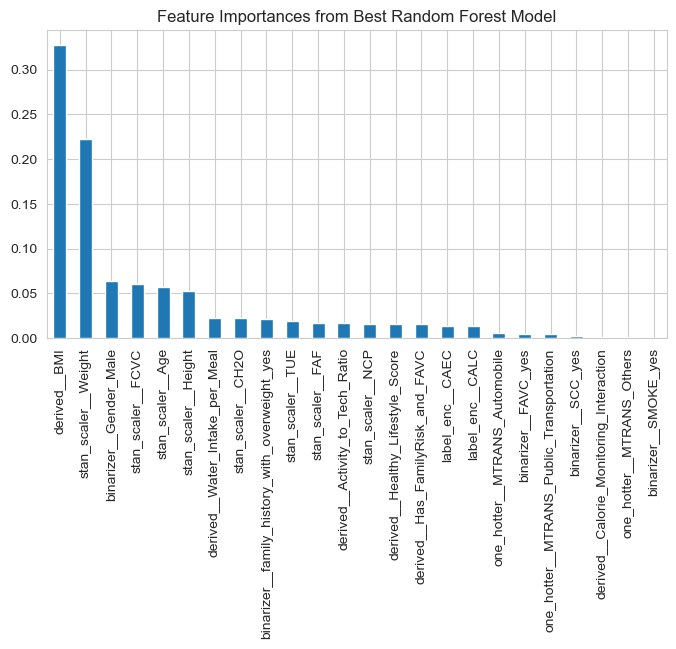

In [72]:
pd.Series(gs_model.best_estimator_.feature_importances_, index=ds_source_transf.columns).sort_values(
    ascending=False).plot(kind='bar', figsize=(8, 4))
plt.title("Feature Importances from Best Random Forest Model")
plt.show()

In [ ]:
gs_model.best_params_

In [80]:
seed = np.random.randint(0, 10000)
print('seed', seed)
dt_model = skl.tree.DecisionTreeClassifier(random_state=seed)
ada_model = skl.ensemble.AdaBoostClassifier(estimator=dt_model, random_state=seed)
gs_model = skl.model_selection.GridSearchCV(estimator=ada_model, param_grid={
    'n_estimators': range(245, 255),
    'estimator__max_depth': [9, 10, 11]
}, scoring='accuracy', cv=5, n_jobs=14, verbose=2)
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_ADA', gs_model)
chime.success()

seed 7204
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Params {'estimator__max_depth': 10, 'learning_rate': 1, 'n_estimators': 250}
Train  1.0
Test   0.8921789507563566


In [88]:
len(ds_labels.unique())

7

In [94]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob'
    num_class=len(ds_labels.unique()),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=seed
)
param_grid = {
    'n_estimators': [204],
    'max_depth': [4],
    'learning_rate': [0.1],
    'subsample': [0.64, 0.65, .66],
    'colsample_bytree': [.75, .76]
}
gs_model = skl.model_selection.GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy',
                                            cv=3, n_jobs=14, verbose=3)
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_XGB', gs_model)
chime.success()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Params {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 204, 'subsample': 0.65}
Train  0.9490584258812168
Test   0.8979723205664628


In [96]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob'
    num_class=len(ds_labels.unique()),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=seed
)
param_grid = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [.8],
    'colsample_bytree': [.8]
}
gs_model = skl.model_selection.GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy',
                                            cv=3, n_jobs=14, verbose=3)
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_XGB', gs_model)
chime.success()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Params {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Train  0.9278931273136971
Test   0.895397489539749


In [134]:
seed = np.random.randint(0, 10000)
print('seed', seed)
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(data_x, data_y, test_size=0.2,
                                                                        random_state=seed)
dists = []
for i in range(data_test.shape[0]):
    # dists.append(((data_test[i] - x_train) ** 2).sum(axis=1).argmin())
    indices = ((data_test[i] - x_train) ** 2).sum(axis=1).argsort()[:2]
    dists.append(indices[0])
    dists.append(indices[1])
print((((data_test - x_train[dists[::2]]) ** 2).sum(axis=1) ** 0.5).mean())

seed 797
1.1538748510714392


In [137]:
seed = 1745
print('seed', seed)
dt_model = skl.tree.DecisionTreeClassifier(random_state=seed, max_depth=10)
ada_model = skl.ensemble.AdaBoostClassifier(estimator=dt_model, random_state=seed, n_estimators=250)
ada_model.fit(x_train[dists], y_train[dists])
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('CH_ADA', gs_model)
chime.success()

seed 1745
Params {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Train  0.9197650088524062
Test   0.9279047312520116


In [136]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob'
    num_class=len(ds_labels.unique()),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=seed,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)
xgb_model.fit(x_train[dists], y_train[dists])
print('Train ', xgb_model.score(x_train, y_train))
print('Test  ', xgb_model.score(x_test, y_test))
save_submission('CH_XGB', xgb_model)
chime.success()

Train  0.9125221310156124
Test   0.9079497907949791
